## logistic regression with sparse parameter SGD

The main idea here is to do SGD updates _only_ on the affected locations of the parameter vector. Let $X$ be the $n$ by $p$ sparse design matrix. Let $y$ be the n-vector of binary responses. Let $\sigma = 1 / (1 + \exp(-\cdot))$. In the case of logistic regression, with regression coefficients $\beta$ and $\Psi_i = \sum_j x_{ij} \beta_j$, the likelihood is given by
$$
\log \Pi^n_i \frac{\exp( \Psi_i y_i )}{1 + \exp( \Psi_i y_i )} = \sum \Psi_i y_i - \log(1 + \exp( \Psi_i y_i ))
$$
The derivative with respect to $\beta$ is given by
$$
\sum (y_i - \sigma(\Psi_i))x_i
$$
For SGD, we will update just one example $i$ and add a ridge penalty, giving
$$
\beta^{K+1}_j = \beta^K_j + \eta (y_i - \sigma(\Psi_i))x_{ij} - \eta \lambda \beta_j^K
$$
However, since $X$ is sparse, we expect most of the elements of a random row $i$, denoted by $x_i$, to be zero. Let $A$ be the set of nonzero indices and let $x_i(A)$ and $\beta(A)$ be the subvectors on $A$. For $j \in A$, the update is
$$
\beta^{K+1}_j = \beta^K_j + \eta (y_i - \sigma(\Psi_i(A))x_{ij} - \eta \lambda \beta_j^K
$$
If $j \not \in A$:
$$
\beta^{K+1}_j = \beta^K_j - \eta \lambda \beta_j^K = \beta^K_j(1 - \eta \lambda)
$$
Now we can state the purpose of the code here. We record the last time $j \in A$, say iteration $K^{'}$. The next time $j \in A$, say iteration $K$, we take two steps. First
$$
\beta^{K+1}_j = \beta^{K^{'}}_j(1 - \eta \lambda)^{K - K^{'} - 1},
$$
and second, we perform the usual update rule for $j$ in the active set.

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# data generation
from scipy.special import expit
from scipy.sparse import rand as sparse_rand

n = 10000
p = 100

rng = np.random.RandomState(800)
X = csr_matrix(sparse_rand(n, p, density=.1))
beta = rng.normal(0, 1, p)
Xb = X.dot(beta)
p = expit(Xb)
y = rng.binomial(1, p)

In [3]:
def update(X, y, beta_dict, gap_count, rng, it, nrow, eta, la):
    ii = rng.randint(0, nrow)
    x = X.getrow(ii)
    A = x.indices
    xA = x.data
    betaA = np.zeros(A.shape)
    pen = np.zeros(A.shape)

    for jjA, jj in enumerate(A):
        betaA[jjA] = beta_dict[jj]
        pen[jjA] = (1 - eta * la) ** (it - gap_count[jj] - 1)
        gap_count[jj] = it        

    betaA = betaA * pen
    xAbetaA = xA.dot(betaA)
    grad_penalty = (y[ii] - expit(xAbetaA)) * xA - la * betaA
    betaA = betaA + eta * grad_penalty

    for jj, beta in zip(A, betaA):
        beta_dict[jj] = beta


def sparse_sgd(X, y, eta, la, seed, maxit=100):
    nrow, p = X.shape
    rng = np.random.RandomState(seed)

    beta_dict = {}
    gap_count = {}
    for v in range(p):
        beta_dict[v] = rng.normal(0, .001)
        gap_count[v] = 0

    it = 0
    while it < maxit:
        it += 1
        update(X, y, beta_dict, gap_count, rng, it, nrow, eta, la)

    beta = np.zeros(p)
    for k in beta_dict:
        beta[k] = beta_dict[k]

    return beta

In [4]:
betahat = sparse_sgd(X, y, eta=.01, la=.01, seed=123, maxit=100000)

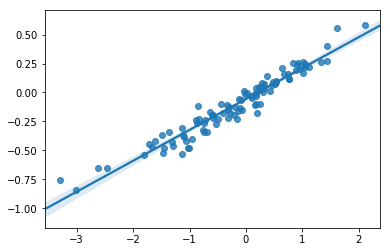

In [5]:
sns.regplot(beta, betahat)